# HVSR computing and plotting code

In [ ]:
## ----Importing necessary stuff----
import os  # Handling filesystems
import warnings
 
# Ignoring a silly warning from HVSRPY and PANDAS
warnings.simplefilter("ignore", UserWarning) 
warnings.simplefilter("ignore", RuntimeWarning) 
warnings.simplefilter("ignore", RuntimeWarning) 

import numpy as np  # Numerical array management
import matplotlib.pyplot as plt  # Plot results
from matplotlib.collections import LineCollection
from matplotlib import spines
from tqdm import tqdm  # To track progress of HVSR computations
from scipy.signal import ShortTimeFFT
from scipy.signal.windows import hann
from scipy.integrate import romb, cumulative_simpson, simpson
import pandas as pd

plt.rcParams['date.converter'] = 'concise'
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'

from obspy.clients.filesystem.sds import Client  # Locally stored data
from obspy import read, read_inventory, UTCDateTime  # Creating datetime objects

import hvsrpy  # Dear goodness
from hvsrpy import preprocess, process, TimeSeries, SeismicRecording3C, settings, sesame
from hvsrpy import frequency_domain_window_rejection as window_rejection

from IPython.display import clear_output

## Calculating

In [2]:
# sds = '/Users/roberto/Documents/colima-data/sds'

In [3]:
# inv = read_inventory('/Users/roberto/Documents/colima-data/response/MNGR.xml')
# for canal in inv[0][0]:
#     canal.location_code = '00'

In [4]:
# ## ----Setting up OBSPY client----
# client = Client(sds)
# net = 'UC'  # Universidad de Colima
# sta = 'MNGR'  # Montegrande
# loc = '00'
# cha = 'HH*'  # Every broadband channel

In [5]:
# st = client.get_waveforms(net, sta, loc, cha, UTCDateTime(2015,1,1), UTCDateTime(2015,1,2))
# st

In [6]:
## ----Setting up HVSRPY----
freq1 = 1
freq2 = 25
nfreqs = 200
freqs = np.geomspace(freq1,freq2,nfreqs)

# Preprocessing (detrend, window length, bandpass filter)
preproc = settings.HvsrPreProcessingSettings()  # Init 
preproc.detrend = 'linear'
preproc.window_length_in_seconds = 60  # why no overlap?
preproc.filter_corner_frequencies_in_hz = [0.1, 49.0]
print('-'*60)
print('Preprocessing Summary')
print('-'*60)
preproc.psummary()

# Processing for traditional HVSR
proc = settings.HvsrTraditionalProcessingSettings()  # Init
proc.window_type_and_width = ('tukey', 0.2)
proc.smoothing = dict(operator = 'konno_and_ohmachi',
                      bandwidth = 40,
                      center_frequencies_in_hz = freqs)
proc.method_to_combine_horizontals = 'geometric_mean'
print('-'*60)
print('Processing Summary for Traditional HVSR')
print("-"*60)
proc.psummary()

# Processing for single-azimuth HVSR (east)
proc_east = settings.HvsrTraditionalSingleAzimuthProcessingSettings()
proc_east.window_type_and_width = ('tukey', 0.2)
proc_east.smoothing = dict(operator = 'konno_and_ohmachi',
                           bandwidth = 40,
                           center_frequencies_in_hz = freqs)
proc_east.azimuth_in_degrees = 90
print('-'*60)
print('Processing Summary (East)')
print("-"*60)
proc_east.psummary()

# Window rejection
n = 2

------------------------------------------------------------
Preprocessing Summary
------------------------------------------------------------
hvsrpy_version                           : 2.0.0
orient_to_degrees_from_north             : 0.0
filter_corner_frequencies_in_hz          : [0.1, 49.0]
window_length_in_seconds                 : 60
detrend                                  : linear
preprocessing_method                     : hvsr
------------------------------------------------------------
Processing Summary for Traditional HVSR
------------------------------------------------------------
hvsrpy_version                           : 2.0.0
window_type_and_width                    : ('tukey', 0.2)
smoothing                                :
     operator                            : konno_and_ohmachi
     bandwidth                           : 40
     center_frequencies_in_hz            : [1.0, 1.016306783052 ... 9887153848541, 25.0]
fft_settings                             : None
handl

In [7]:
def HVSR_FULL_FROM_ST(stream,preproc,proc):
    '''
    Feed it a pre-merged Obspy Stream object
    for simplicity's sake
    '''
    # Load waveforms to HVSRPY
    source = SeismicRecording3C(
        TimeSeries(
            stream.select(component='N')[0].data,
            stream.select(component='N')[0].stats.delta
        ), 
        TimeSeries(
            stream.select(component='E')[0].data,
            stream.select(component='E')[0].stats.delta
        ), 
        TimeSeries(
            stream.select(component='Z')[0].data,
            stream.select(component='Z')[0].stats.delta
        )
    )
    srecords = preprocess(source,preproc)
    hvsr = process(srecords,proc)
    window_rejection(hvsr,n=n,search_range_in_hz=(1,20))
    
    return hvsr

In [8]:
def HVSR_EAST_FROM_ST(stream, preproc, proc):
    '''
    Feed it a pre-merged Obspy Stream object
    for simplicity's sake
    '''
    # Load waveforms to HVSRPY
    source = SeismicRecording3C(
        TimeSeries(
            stream.select(component='E')[0].data,
            stream.select(component='E')[0].stats.delta
        ),
        TimeSeries(
            stream.select(component='E')[0].data,
            stream.select(component='E')[0].stats.delta
        ),
        TimeSeries(
            stream.select(component='Z')[0].data,
            stream.select(component='Z')[0].stats.delta
        )
    )
    srecords = preprocess(source, preproc)
    hvsr = process(srecords, proc)
    window_rejection(hvsr, n=n, search_range_in_hz=(1,20))

    return hvsr

In [9]:
def datetimedayparser(utcdatetime):
    year = utcdatetime.year
    month = utcdatetime.month
    day = utcdatetime.day
    return f"{year}-{month}-{day}"

In [10]:
# ptime = UTCDateTime(2015,1,1)

# totaldays = 365

# days = []
# dates = []
# mpldates = []
# curves_full = []
# curves_east = []

# avgamps_Z = []

# peak_f0_freqs_full = []
# peak_f0_amps_full = []
# peak_f0_freqs_east = []
# peak_f0_amps_east = []

# mean_f0_freqs_full = []
# mean_f0_amps_full = []
# mean_f0_freqs_east = []  
# mean_f0_amps_east = []  


In [11]:
# for i in tqdm(range(totaldays)):
#     try:
#         stime = ptime + i * 86400
#         etime = stime + 86400
#         day_julian = i 
#         # Read waveforms
#         st = client.get_waveforms(net, sta, loc, cha, stime, etime)
#         st.merge(fill_value = 0)
#         st.remove_sensitivity(inventory=inv)
#         st.detrend('linear')
#         st.filter('highpass',freq=1)
#         ampdata = np.mean(np.abs(st.select(component='Z')[0].data))
#         # # Load waveforms to HVSRPY
#         hv_full = HVSR_FULL_FROM_ST(st,preproc,proc)
#         hv_east = HVSR_EAST_FROM_ST(st,preproc,proc)

#         curve_full = hv_full.mean_curve()
#         curves_full.append(curve_full)
#         curve_east = hv_east.mean_curve()
#         curves_east.append(curve_east)


#         days.append(day_julian)
#         dates.append(stime)
#         mpldates.append(stime.matplotlib_date)
#         avgamps_Z.append(ampdata)


#         peak_full_f, peak_full_a = hv_full.mean_curve_peak()
#         peak_east_f, peak_east_a = hv_east.mean_curve_peak()

#         peak_f0_freqs_full.append(peak_full_f)
#         peak_f0_amps_full.append(peak_full_a)
#         peak_f0_freqs_east.append(peak_east_f)
#         peak_f0_amps_east.append(peak_east_a)

#         mean_full_f = hv_full.mean_fn_frequency()
#         mean_full_a = hv_full.mean_fn_amplitude()
#         mean_east_f = hv_east.mean_fn_frequency()
#         mean_east_a = hv_east.mean_fn_amplitude()

#         mean_f0_freqs_full.append(mean_full_f)
#         mean_f0_amps_full.append(mean_full_a)
#         mean_f0_freqs_east.append(mean_east_f)
#         mean_f0_amps_east.append(mean_east_a)

#     except:
#         pass
# plotdates = np.array(dates).astype('datetime64[s]')

In [12]:
# d_hv = {'day':days,'date':dates,'mpldate':mpldates,'curves_east':curves_east,'curves_full':curves_full,
#         'peak_east_f':peak_f0_freqs_east,'peak_east_a':peak_f0_amps_east,
#         'peak_full_f':peak_f0_freqs_full,'peak_full_a':peak_f0_amps_full,
#         'mean_east_f':mean_f0_freqs_east,'mean_east_a':mean_f0_amps_east,
#         'mean_full_f':mean_f0_freqs_full,'mean_full_a':mean_f0_amps_full}

In [13]:
# df_hv = pd.DataFrame(data=d_hv)
# df_hv.to_json('hvsr_colima_24h.json')

## Plotting

In [14]:
df_hv = pd.read_json('hvsr_colima_24h.json')
df_hv.head()

,day,date,mpldate,curves_east,curves_full,peak_east_f,peak_east_a,peak_full_f,peak_full_a,mean_east_f,mean_east_a,mean_full_f,mean_full_a
0,0,"{'DEFAULT_PRECISION': 6, 'date': 1420070400000...",16436,"[1.5100664324, 1.5029417006, 1.492066539800000...","[1.416924689, 1.4064789071, 1.3933860775, 1.37...",4.084696,2.386179,4.019156,2.184369,4.594905,2.813053,4.513645,2.467677
1,1,"{'DEFAULT_PRECISION': 6, 'date': 1420156800000...",16437,"[1.4758297052, 1.4776174344, 1.478499830700000...","[1.3949869977, 1.3935612056, 1.389911868, 1.38...",5.206334,2.366513,3.954668,2.160003,4.577628,2.806220,4.574177,2.461278
2,2,"{'DEFAULT_PRECISION': 6, 'date': 1420243200000...",16438,"[1.3965152525, 1.4050583857, 1.415632597200000...","[1.3407769602, 1.340486752, 1.3419857094, 1.34...",5.291233,2.376593,5.291233,2.159272,4.616208,2.795881,4.615765,2.452763
3,3,"{'DEFAULT_PRECISION': 6, 'date': 1420329600000...",16439,"[1.5349026165000001, 1.5232253809, 1.507721110...","[1.4317200063, 1.414563465, 1.3943243511, 1.37...",4.084696,2.371169,4.019156,2.153271,4.634503,2.788605,4.573323,2.443291
4,4,"{'DEFAULT_PRECISION': 6, 'date': 1420416000000...",16440,"[1.5738498916, 1.5680575758000002, 1.556983318...","[1.4564144030000001, 1.4485902458, 1.437586092...",4.084696,2.372749,4.019156,2.151667,4.588288,2.780844,4.579575,2.437121


Explanation:
- `day`: days passed since midnight, January 1st 2015 (UTC)
- `date`: start date and time of seismic record giving an individual HVSR curve
- `mpldate`: miscellaneous, unused
- `curves_east`: daily curves for east-only HVSR
- `curves_full`: daily curves for two-component HVSR, averaged geometrically
- `peak_`: peak (in frequency and amplitude) for daily HVSR curve
- `mean_`: mean frequency and amplitude from all the HVSR curves which, when averaged, result in a daily curve

In [60]:
curves_east_pd = df_hv['curves_east']
curves_full_pd = df_hv['curves_full']
curves_east = np.zeros((len(curves_east_pd),len(freqs)))
curves_full = np.zeros((len(curves_full_pd),len(freqs)))
for i in range(len(curves_east_pd)):
   curves_east[i,:] = np.array(curves_east_pd[i])
   curves_full[i,:] = np.array(curves_full_pd[i])


In [32]:
df_hv['date'][180]  # the day before the flows were deposited

{'DEFAULT_PRECISION': 6,
 'date': 1436486400000,
 'datetime': 1436486400000,
 'day': 10,
 'hour': 0,
 'julday': 191,
 'matplotlib_date': 16626.0,
 'microsecond': 0,
 'minute': 0,
 'month': 7,
 'ns': 1436486400000000000,
 'precision': 6,
 'second': 0,
 'time': '00:00:00',
 'timestamp': 1436486400.0,
 'weekday': 4,
 'year': 2015}

In [ ]:
df_hv['date'][182]  # the day after the flows were deposited

{'DEFAULT_PRECISION': 6,
 'date': 1436659200000,
 'datetime': 1436659200000,
 'day': 12,
 'hour': 0,
 'julday': 193,
 'matplotlib_date': 16628.0,
 'microsecond': 0,
 'minute': 0,
 'month': 7,
 'ns': 1436659200000000000,
 'precision': 6,
 'second': 0,
 'time': '00:00:00',
 'timestamp': 1436659200.0,
 'weekday': 6,
 'year': 2015}

In [64]:
# Separating between pre-PDC and post-PDC HVSR measurements
curves_east_pre  = curves_east[:181]
curves_east_post = curves_east[182:]
curves_full_pre  = curves_full[:181]
curves_full_post = curves_full[182:]

In [67]:
# Creating the BIG HVSR curves
hv_east_pre  = hvsrpy.HvsrTraditional(freqs, curves_east_pre)
hv_east_post = hvsrpy.HvsrTraditional(freqs, curves_east_post)
hv_full_pre  = hvsrpy.HvsrTraditional(freqs, curves_full_pre)
hv_full_post = hvsrpy.HvsrTraditional(freqs, curves_full_post)

In [72]:
window_rejection(hv_east_pre,2,50)
window_rejection(hv_east_post,2,50)
window_rejection(hv_full_pre,2,50)
window_rejection(hv_full_post,2,50)

1

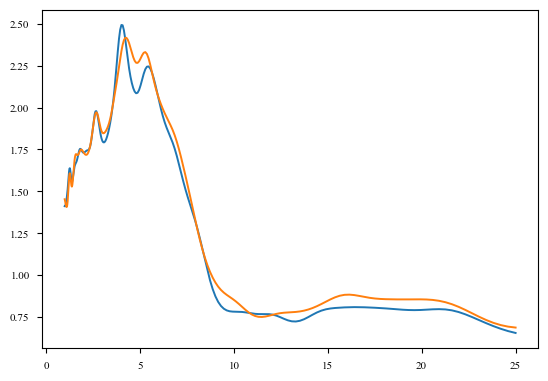

In [73]:
plt.plot(hv_east_pre.frequency,hv_east_pre.mean_curve())
plt.plot(hv_east_post.frequency,hv_east_post.mean_curve())

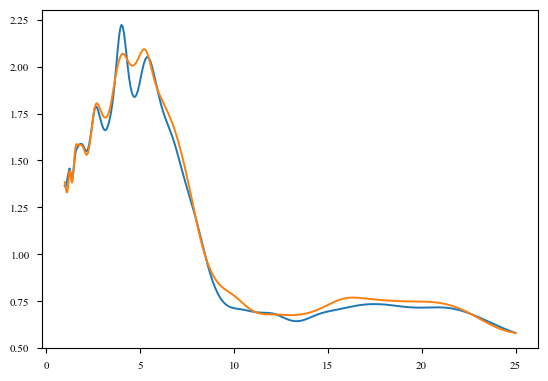

In [74]:
plt.plot(hv_full_pre.frequency,hv_full_pre.mean_curve())
plt.plot(hv_full_post.frequency,hv_full_post.mean_curve())

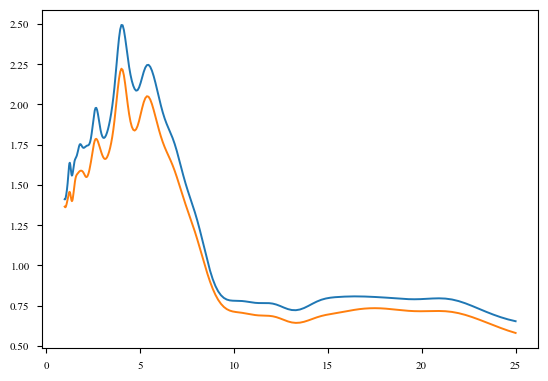

In [76]:
plt.plot(hv_east_pre.frequency,hv_east_pre.mean_curve())
plt.plot(hv_full_pre.frequency,hv_full_pre.mean_curve())

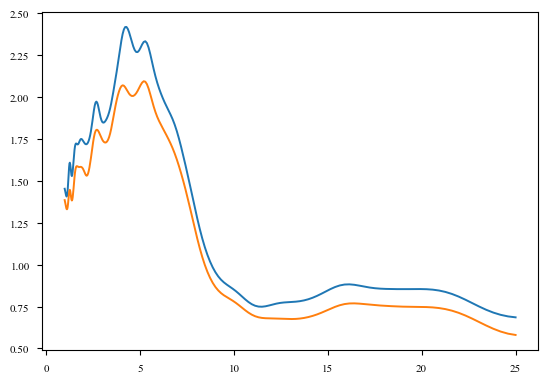

In [77]:
plt.plot(hv_east_post.frequency,hv_east_post.mean_curve())
plt.plot(hv_full_post.frequency,hv_full_post.mean_curve())

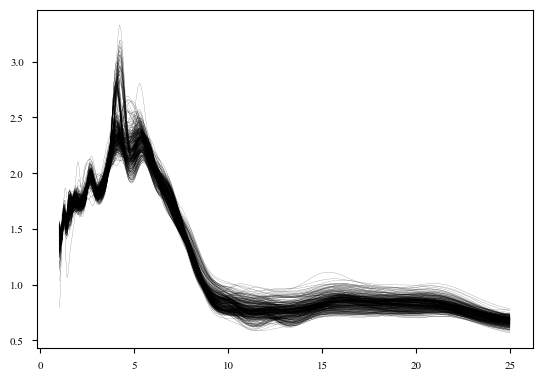

In [87]:
for i in range(curves_east[:,0].shape[0]):
    plt.plot(freqs,curves_east[i],linewidth=0.1,c='k')

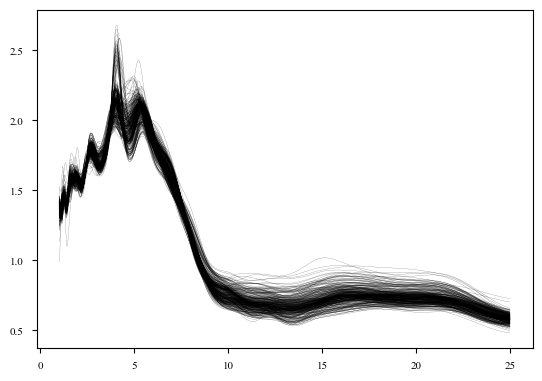

In [88]:
for i in range(curves_full[:,0].shape[0]):
    plt.plot(freqs,curves_full[i],linewidth=0.1,c='k')